This code seeks to identify what the best way to optimize a listing on Neighbor.com is. We seek to identify specific features that are correlated with reservation status. The project is organized as follows
1. Import Libraries
2. Pull in Data
3. Clean Data
4. Feature Engineering/Deal with Missing Values
5. Model

#  1. Import Libraries

In [225]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# 2. Pull in Data

These strings in red need to be replaced with the path of the corresponding files on your computer. These files should be updated periodally by requesting them from preferably Colton Gardner or anyone who can use SQL to pull data from the website.

In [226]:
# Read in Data Tables

# listings.csv
listings = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\listings.csv')
# users.csv
users = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\users.csv')
# reservations.csv
reservations = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\reservations.csv')
# risting_metadata.csv
listingmeta = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\listing_metadata.csv')
# photos.csv
photos = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\photos.csv')
# user_metadata.csv
usermeta = pd.read_csv('C:\\Users\\ben1c\\Projects\\Econ 484\\Final Project\\user_metadata.csv')

In [227]:
# Drop all duplicates, deleted posts or any that aren't published
listings.drop_duplicates()
listings = listings[listings.status == 'Published']
listings = listings[listings['deleted'] != 'True']

# Return user data from hosts only
users = users[users['is_host']==True]

The following cell deletes all listings from the last thirty days because they are not representative of the sample we are running this regression on.

In [228]:
# Delete listings made in the last 30 days
listings = listings[pd.to_datetime(listings['created_at']) <= pd.datetime.now().date()-relativedelta(months=1)]

# 3. Clean Data

In [229]:
# Creates new column with Description Length Boolean
listings['Description Length'] = np.where(listings['summary'].str.len()>=30, '1', '0')

# Creates new column with Title Length Boolean
listings['Title Length'] = np.where((listings['listing_name'].str.len()>=10), 1, 0)

# Create Storage Type Category
listings['Storage Type'] = listings['storage_type'].values

# Create Accessibility Category
listings['Accessibility'] = listings['access'].values

# Create Price Per Square Ft
listings['Price Per SQFT'] = (listings['monthly_price'].values)/(listings['width'].values * listings['length'].values)

# Create Day Posted
listings['Day Posted'] = pd.to_datetime(listings['created_at']).dt.dayofweek

# Create Month Posted
listings['Month Posted'] = pd.to_datetime(listings['created_at']).dt.month

In [230]:
#USER METADATA

#picking relevant columns
dfusermeta = pd.DataFrame(usermeta, columns=['id','user_id','key','value'])
df12 = pd.DataFrame(usermeta, columns=['id','user_id','key','value'])

#New column with superhost level inputted
dfusermeta['Superhost Level'] = dfusermeta[dfusermeta['key']=='superhost_level']['value'].astype(int)
df12['Superhost Level'] = np.where(dfusermeta['key']=='superhost_level',dfusermeta['value'],'0')
df123 = df12.loc[df12['Superhost Level']!='0']
users = pd.merge(users, df123[['user_id', 'Superhost Level']], left_on='id', right_on='user_id', how='left')


#Pull in enterprise status
dfusermeta['Enterprise'] = dfusermeta[dfusermeta['key']=='enterprise_account']['value']
df12['Enterprise'] = np.where(dfusermeta['key']=='enterprise_account', '1', '0')
df124 = df12.loc[df12['Enterprise']!='0']
users = pd.merge(users, df124[['user_id', 'Enterprise']], left_on='id', right_on='user_id', how='left')

In [231]:
#LISTING METADATA
df1 = pd.DataFrame(listingmeta, columns= ['id','listing_id','key','value',])
df23 = pd.DataFrame(listingmeta, columns= ['id','listing_id','key','value',])

# 4. Feature Engineering
### Fix Price Score/Manual Score

Price score ranges from 0 to 1 with .5 being the best score. We manipulated price score such that its range is from -.5 to 0 where a value of 0 represents the best possible score and a value of -.5 means that the assigned price score was .5 away form the ideal price score of .5. Therefore, if you were given a score of .7 (your price is higher than our recommendation) then the value in the column would read in as -.2 because you were .2 away from the ideal price score. We did this to make the coefficient on price score easier to understand.

In [232]:
#Pull price score data
df23['Price Score'] = np.where(df1['key']=='price_score',df1['value'],'0')
df234 = df23.loc[df23['Price Score']!='0']
df234['Price Score'] = -(abs(df234['Price Score'].astype(float) + -.5))

listings = pd.merge(listings, df234[['listing_id', 'Price Score']], left_on='id', right_on='listing_id', how='left')

#First Month Discount
df23['Discount'] = np.where(df1['key']=='first_month_discount',df1['value'],'0')
df234 = df23.loc[df23['Discount']!='0']
listings = pd.merge(listings, df234[['listing_id', 'Discount']], left_on='id', right_on='listing_id', how='left')

#Pull manual score data
df23['Manual Score'] = np.where(df1['key']=='manual_score',df1['value'],'0')
df234 = df23.loc[df23['Manual Score']!='0']
listings = pd.merge(listings, df234[['listing_id', 'Manual Score']], left_on='id', right_on='listing_id', how='left')

In [233]:
#Pull feature data
dffeat = pd.DataFrame(listingmeta, columns= ['id','listing_id','key','value'])
dffeat = dffeat[dffeat['key']=='features']
dffeat.drop('key', axis = 1, inplace=True)

dffeat1 = dffeat['value'].str.split(pat=",",expand=True)      
dffeat1 = pd.get_dummies(dffeat1.apply(pd.Series).stack()).sum(level=0)
dffeat1['id'] = dffeat['listing_id']

Some of the features are listed twice in the original dataframe so we will replace any values of 2 with a 1

In [234]:
dffeat1.replace(2, 1, inplace=True)

In [235]:
listings = pd.merge(listings, dffeat1, on='id', how='left')

In [236]:
#USERS
#picking relevant columns
dfusers = pd.DataFrame(users, columns= ['id','bio','is_host','profile_photo_id' , 'lead_source'])

#return user data from hosts only
dfusers = dfusers[dfusers['is_host']==True]

#if they have a bio, counts the number of characters
dfusers['bio length'] = np.where(dfusers['bio'].isna(), 0, 1)

#Add new column, if they have profile pic then '1' else '0'
dfusers['Profile Photo'] = np.where(dfusers['profile_photo_id'].notnull().values,'1','0')

In [237]:
#PHOTOS

#picking relevant columns
dfphoto = pd.DataFrame(photos, columns= ['id','imageable_type','imageable_id','filename', 'deleted'])
dfphoto2 = pd.DataFrame(photos, columns= ['id','imageable_type','imageable_id','filename', 'deleted'])

#returning only undeleted listing photo data
dfphoto = dfphoto[dfphoto['imageable_type']=='Listing']

#insert new column for streetview and label with 1 and 0 for rows with streetview
dfphoto2['streetview'] = np.where((dfphoto2['filename']=='streetView') |(dfphoto2['filename']=='streetview'),'1','0')


dfphoto3 = dfphoto2.loc[dfphoto2['streetview']=='1']
dfphoto3 = dfphoto3[dfphoto3['deleted']==False]

#Add streetview count on listing df
listings = pd.merge(listings, dfphoto3[['imageable_id','streetview']], left_on='id', right_on='imageable_id', how='left')


#count number of pictures for a listing
dfphoto['Frequency'] = dfphoto.groupby('imageable_id')['imageable_id'].transform('count')

#drop duplicate rows for the same listing
dfphoto.drop_duplicates('imageable_id', inplace=True)
dfphoto = dfphoto[dfphoto['deleted']==False]

#Add number of pictures on a listing to listing df
listings = pd.merge(listings, dfphoto[['imageable_id','Frequency']], left_on='id', right_on='imageable_id', how='left')

In [238]:
# Merge the listing and user data together
listings = pd.merge(listings,
                    users,
                    left_on='user_id',
                    right_on='id',
                    how='left')

In [239]:
# Get Reservation info
reservations.drop_duplicates()

,id,user_id,listing_id,start_date,end_date,Reservation_Length,price_at_reservation,first_charge_amount,total,created_at,updated_at,status,extended,nonterminal_monthly,host_new_unread_new_reservation,host_new_unread_canceled_reservation,renter_new_reservation_status_update,six_hour_warn,twelve_hour_warn,last_hour_warn,eviction_request,eviction_reason,eviction_confirmed,eviction_confirmation_security_code,weeks_notice_notification,moved_out_confirmed_by_renter,moved_out_confirmed_by_host,moveout_security_code,moveout_security_code_created_at,extension_security_code,extension_security_code_created_at,storing
0,55,1301,67,11/16/2017,12/16/2017,30.0,55.00,55.00,NaN,29:06.5,24:04.4,Denied,False,False,True,False,True,False,False,False,False,NaN,False,NaN,False,False,False,NaN,NaN,NaN,NaN,"Queen sized bed, medium 5 drawer dresser, larg..."
1,89,1379,222,12/21/2017,NaN,699.0,45.00,45.00,NaN,59:09.7,00:42.6,Denied,False,True,True,False,False,True,True,False,False,NaN,False,NaN,False,False,False,NaN,NaN,NaN,NaN,"Clothes in wardrobe boxes, one queen size brok..."
2,661,3912,1439,7/16/2018,NaN,492.0,75.00,75.00,NaN,31:30.7,34:48.1,Closed,False,True,False,True,False,True,False,False,False,NaN,False,NaN,False,True,False,fba7629f4dd5d105101fa56e206790d0f3eecaba6ea0b0...,34:48.1,NaN,NaN,300 chairs
3,41,1197,227,10/20/2017,11/20/2017,31.0,60.00,60.00,NaN,47:17.2,30:27.6,Ended,True,False,True,False,True,False,False,False,False,NaN,False,NaN,True,False,False,NaN,NaN,6b6379c9e44a75a035118b3a9fe7d8c8ffcdf4917c643e...,30:40.9,I need to store a truck and trailer. I am from...
4,687,3980,607,7/31/2018,NaN,477.0,65.00,65.00,NaN,39:47.3,39:47.6,Denied,False,True,False,False,True,True,True,False,False,NaN,False,NaN,False,False,False,NaN,NaN,NaN,NaN,2018 Lexus ES 350
5,68,1357,341,1/1/2018,NaN,688.0,100.00,100.00,NaN,13:18.1,26:22.0,Denied,False,True,True,False,True,False,False,False,False,NaN,False,NaN,False,False,False,NaN,NaN,NaN,NaN,I wil be storing furniture and painting equipm...
6,40,1196,279,10/23/2017,11/20/2017,28.0,0.01,0.01,NaN,11:21.7,13:05.9,Denied,False,False,True,False,True,False,False,False,False,NaN,False,NaN,False,False,False,NaN,NaN,NaN,NaN,I am planning to store a bike and a stroller. ...
7,64,1197,227,11/20/2017,NaN,730.0,60.00,60.00,NaN,30:24.7,21:12.1,Ended,False,True,False,True,True,False,False,False,False,NaN,False,NaN,False,True,True,604b556c2383b6b4bd1e24b5fb23f51036cb33c808b744...,21:12.0,NaN,NaN,NaN
8,92,1448,341,12/26/2017,1/26/2018,31.0,100.00,100.00,NaN,28:31.3,01:11.9,Denied,False,False,True,False,False,True,True,False,False,NaN,False,NaN,False,False,False,NaN,NaN,NaN,NaN,1999 Jeep Grand Cherokee\n\n
9,707,4154,1958,7/27/2018,NaN,481.0,125.00,62.50,NaN,58:03.5,10:11.7,Denied,False,True,False,False,True,False,False,False,False,NaN,False,NaN,False,False,False,NaN,NaN,NaN,NaN,Jet ski trailer and two kayaks that fit under ...


In [240]:
# Create Reservation Length Status
# listings = listings.assign(Reserved=listings.id.isin(reservations.listing_id).astype(int))
listings = pd.merge(listings, reservations[['listing_id', 'Reservation_Length']], left_on='id_x', right_on='listing_id', how='left')

In [241]:
finaldf = pd.DataFrame()

# Bring in Listing Info
finaldf['Listing-ID'] = listings['id_x']
finaldf['Accessibility'] = listings['Accessibility']
finaldf['Storage Type'] = listings['Storage Type']
finaldf['Title Length'] = listings['Title Length']
finaldf['Description Length'] = listings['Description Length']
finaldf['Indoor'] = listings['indoor']
finaldf['Day Posted'] = listings['Day Posted']
finaldf['Month Posted'] = listings['Month Posted']
finaldf['Photos of the Space'] = listings['Frequency']
finaldf['Streetview'] = listings['streetview']
finaldf['Discount'] = listings['Discount']
finaldf['Price Per SQFT'] = listings['Price Per SQFT']

# Bring in Host Info
finaldf['Bio Included'] = dfusers['bio length']
finaldf['Profile Photo'] = dfusers['Profile Photo']
finaldf['Phone Verified'] = listings['phone_verified']
finaldf['Photo ID Verified'] = listings['photo_id_verified']
finaldf['Superhost Level'] = listings['Superhost Level']
finaldf['Camera'] = listings['camera']
finaldf['Climate Controlled'] = listings['climate_controlled']
finaldf['Lockable'] = listings['is_lockable']
finaldf['No Pets'] = listings['no_pets']
finaldf['No Stairs'] = listings['no_stairs']
finaldf['Private Entrance'] = listings['private_entrance']
finaldf['Smoke Detectors'] = listings['smoke_detectors']
finaldf['Smoke Free'] = listings['smoke_free']
finaldf['Enterprise'] = listings['Enterprise']

# Bring in Review info
finaldf['Manual Score'] = listings['Manual Score']
finaldf['Price Score'] = listings['Price Score']

# Add Reserved Info
finaldf['Reservation Length'] = listings['Reservation_Length']
finaldf.dropna(subset=['Reservation Length'], inplace=True)

In [242]:
finaldf.drop_duplicates(inplace=True)
missingdata = pd.DataFrame()
missingdata['total'] = finaldf.isnull().sum()
missingdata['percent'] = missingdata['total'] / len(missingdata)
missingdata.sort_values('percent', ascending = False).head(5)

,total,percent
Enterprise,1223,42.172414
Streetview,1118,38.551724
Photos of the Space,321,11.068966
Discount,307,10.586207
No Pets,104,3.586207


# Cleaning missing values
#### The following are our reasoning on filling these missing values with zeroes

Discount-maybe it didn't exist in the beginning so some of the early ones are are NaN, replace t/f with TRUE/FALSE, then Fill with ZERO  
Features - 108 are missing for them all and it appears that they are the same listings, seems like they are outside so it probably means that they just don't have any of those features. FILL WITH ZERO  
Price Score- I don't see anything special. DROP ROW  
Manual Score- I don't see anything special. DROP ROW  
Phone Verified- Fill with zeros  
Superhost level - FIll with Zeros  
Bio Length- Fill with Zero  
Photos of Space- FIll with Zero, because there are no zero values  
Streetview- Fill with 0 becuase they don't have it.  

In [243]:
finaldf.replace('true', 1, inplace=True)
finaldf.replace('false', 0, inplace=True)
finaldf.replace('True', 1, inplace=True)
finaldf.replace('False', 0, inplace=True)
finaldf.replace('TRUE', 1, inplace=True)
finaldf.replace('FALSE', 0, inplace=True)
finaldf.replace('f', 0, inplace=True)
finaldf.replace('t', 1, inplace=True)
finaldf.replace(False, 0, inplace=True)
finaldf.replace(True, 1, inplace=True)

In [251]:
finaldf = finaldf.fillna(0)
finaldf = finaldf.dropna()
finaldf

,Listing-ID,Accessibility,Storage Type,Title Length,Description Length,Indoor,Day Posted,Month Posted,Photos of the Space,Streetview,Discount,Price Per SQFT,Bio Included,Profile Photo,Phone Verified,Photo ID Verified,Superhost Level,Camera,Climate Controlled,Lockable,No Pets,No Stairs,Private Entrance,Smoke Detectors,Smoke Free,Enterprise,Manual Score,Price Score,Reservation Length
0,2387,Business Hours,Garage,1,1,True,0,9,8.0,1,1.0,0.525000,0,1,1.0,1.0,3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0,.8,-0.16,321.0
3,2383,24/7,Other,1,1,True,6,9,3.0,0,0.0,0.378788,1,1,1.0,1.0,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0,.35,-0.03,349.0
4,2383,24/7,Other,1,1,True,6,9,3.0,0,0.0,0.378788,0,0,1.0,1.0,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0,.35,-0.03,354.0
5,2383,24/7,Other,1,1,True,6,9,3.0,0,0.0,0.378788,0,0,1.0,1.0,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0,.35,-0.03,234.0
6,1673,24/7,Lot,1,1,False,2,5,4.0,0,0.0,0.262500,0,1,1.0,1.0,6,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0,1,-0.21,480.0
7,1673,24/7,Lot,1,1,False,2,5,4.0,0,0.0,0.262500,0,0,1.0,1.0,6,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0,1,-0.21,479.0
8,1673,24/7,Lot,1,1,False,2,5,4.0,0,0.0,0.262500,0,1,1.0,1.0,6,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0,1,-0.21,475.0
9,1911,By Appointment Only,Basement,1,1,True,3,7,2.0,0,1.0,0.367521,0,0,1.0,1.0,5,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0,1,-0.04,340.0
10,625,By Appointment Only,Other,1,1,True,1,2,3.0,1,0.0,0.321429,0,0,1.0,1.0,3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,.9,-0.16,607.0
12,625,By Appointment Only,Other,1,1,True,1,2,3.0,1,0.0,0.321429,0,1,1.0,1.0,3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,.9,-0.16,607.0


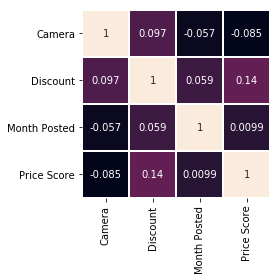

In [245]:
corrl = pd.DataFrame(finaldf, columns=['Camera', 'Manual Score', 'Enterprise',
                                       'Discount', 'Month Posted', 'Superhost Level', 'Price Score'])
correlation_map = corrl.corr()
# correlation_map
plt.figure(figsize=(4,4))
sns.heatmap(correlation_map, vmax=.8, square=True, annot=True, linewidth=.5, cbar=False)

# Take out rows where Reserevation Length = 0

In [246]:
finaldf = finaldf.fillna(0)
missingdata = pd.DataFrame()
missingdata['total'] = finaldf.isnull().sum()
missingdata['percent'] = missingdata['total'] / len(missingdata)
missingdata.sort_values('percent', ascending = False).head(5)

,total,percent
Listing-ID,0,0.0
Photo ID Verified,0,0.0
Price Score,0,0.0
Manual Score,0,0.0
Enterprise,0,0.0


In [252]:
dummies = ['Storage Type', 'Accessibility']
finaldf = pd.get_dummies(finaldf, columns=dummies)

In [253]:
finaldfsumstat = pd.DataFrame(finaldf, columns=['Day Posted', 'Month Posted', 'Photos of the Space',
       'Superhost Level', 'Manual Score',
       'Price Score', 'Reservation Length'])
finaldfsumstat.describe().round(2)
finaldfsumstat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1305 entries, 0 to 3655
Data columns (total 7 columns):
Day Posted             1305 non-null int64
Month Posted           1305 non-null int64
Photos of the Space    1305 non-null float64
Superhost Level        1305 non-null object
Manual Score           1305 non-null object
Price Score            1305 non-null float64
Reservation Length     1305 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 81.6+ KB


# This is where the machine learning actually starts!!!!

In [254]:
X = pd.DataFrame(finaldf, columns = ['Title Length', 'Description Length', 'Indoor',
       'Day Posted', 'Month Posted', 'Photos of the Space', 'Streetview',
       'Discount', 'Bio Included', 'Profile Photo', 'Phone Verified',
       'Photo ID Verified', 'Superhost Level', 'Camera', 'Climate Controlled',
       'Lockable', 'No Pets', 'No Stairs', 'Private Entrance',
       'Smoke Detectors', 'Smoke Free', 'Enterprise', 'Manual Score',
       'Price Score', 'Storage Type_Basement',
       'Storage Type_Bedroom', 'Storage Type_Garage', 'Storage Type_Lot',
       'Storage Type_Other', 'Storage Type_RV Pad',
       'Storage Type_Storage Facility', 'Storage Type_Warehouse',
       'Accessibility_24/7', 'Accessibility_Business Hours',
       'Accessibility_By Appointment Only'])

y = pd.DataFrame(finaldf, columns = ['Reservation Length'])

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
inds = pd.isnull(finaldf).any(1).nonzero()[0]
inds

array([], dtype=int64)

In [256]:
lasso = Lasso()
lasso = lasso.fit(X_train, y_train)
cross = cross_validate(lasso, X, y, cv=3, scoring='neg_mean_squared_error', return_estimator=True)

print('Mean MSE:', cross['test_score'].mean())
feature_imp = sorted(list(zip(X.columns, abs(lasso.coef_))), key=lambda x: x[1], reverse=True)
feature_imp[:5]

Mean MSE: -23631.74890901227


[('Manual Score', 81.10719162106928),
 ('Discount', 77.23051718287262),
 ('No Stairs', 44.42622018318442),
 ('Enterprise', 36.02695928951823),
 ('Smoke Free', 24.823243769755997)]

In [257]:
rfr = RandomForestRegressor(max_features='sqrt')

gridsearch = GridSearchCV(rfr, {'max_depth': [50, 60], 'n_estimators': [300, 350, 400]}, cv=3)

gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))

y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("GridSearch MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'max_depth': 50, 'n_estimators': 400}
GridSearch MSE:
Train Accuracy: 5247.059359933401	Test Accuracy: 20959.9233164904


In [258]:
rfr = RandomForestRegressor(max_features='sqrt', max_depth=50, n_estimators=400)
rfr.fit(X_train, y_train)
feature_imp = sorted(list(zip(X.columns, rfr.feature_importances_)), key=lambda x: x[1], reverse=True)
# pd.Series([x[1] for x in feature_imp[:]], index=[x[0] for x in feature_imp[:]]).plot(kind='bar', figsize=(14, 4))
feature_imp[:5]

[('Month Posted', 0.10574239022462308),
 ('Price Score', 0.1035229056571442),
 ('Photos of the Space', 0.08020222436999346),
 ('Manual Score', 0.07870923277155151),
 ('Profile Photo', 0.06891511190273057)]